### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate

### Load Model

In [2]:
expected_model_version = '1.0'
model_path = '../models/hospital_RR_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

### Load Data

In [3]:
#Data table with hipass of 200 inpatient cases per hospital used to generate fnal model
hosp_data = pd.read_csv('../data/main_df_post2_200.csv')

In [4]:
#Separating out our target/client hospital
targ_hosp = hosp_data[hosp_data.Facility_ID == '310041']

In [5]:
targ_hosp.T

,1410
Facility_ID,310041
City,TOMS RIVER
State,NJ
County,Ocean
Total_Admissions,2877
ReadmissionRate,16.8
HAI_1_SIR,0.732
HAI_2_SIR,0.376
HAI_5_SIR,0.376
HAI_6_SIR,0.415


In [6]:
targ_hosp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 1410 to 1410
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Facility_ID           1 non-null      object 
 1   City                  1 non-null      object 
 2   State                 1 non-null      object 
 3   County                1 non-null      object 
 4   Total_Admissions      1 non-null      int64  
 5   ReadmissionRate       1 non-null      float64
 6   HAI_1_SIR             1 non-null      float64
 7   HAI_2_SIR             1 non-null      float64
 8   HAI_5_SIR             1 non-null      float64
 9   HAI_6_SIR             1 non-null      float64
 10  PSI_3                 1 non-null      float64
 11  PSI_6                 1 non-null      float64
 12  PSI_8                 1 non-null      float64
 13  PSI_9                 1 non-null      float64
 14  PSI_10                1 non-null      float64
 15  PSI_11               

### Refit Model on All Available Data (Excluding Target Hospital)

We want to train a model to predict our client hospital's readmission rate based on data from all of the other hospitals.

In [7]:
X = hosp_data.loc[hosp_data.Facility_ID != "310041", model.X_columns]
y = hosp_data.loc[hosp_data.Facility_ID != "310041", 'ReadmissionRate']

In [8]:
len(X), len(y)

(2472, 2472)

In [9]:
model.fit(X, y)

Pipeline(steps=[('simpleimputer', SimpleImputer()), ('standardscaler', None),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(learning_rate=0.06, max_depth=5,
                                               max_iter=40, random_state=47))])

In [10]:
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [11]:
cv_results['test_score']

array([-0.56345455, -0.6092104 , -0.60614953, -0.54585004, -0.53456143])

In [12]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(0.5718451885282267, 0.030689333455469776)

### Calculate Expected Client Hospital Readmission Rate From the Model

In [13]:
X_client = hosp_data.loc[hosp_data.Facility_ID == "310041", model.X_columns]
y_client = hosp_data.loc[hosp_data.Facility_ID == "310041", 'ReadmissionRate']

In [14]:
client_pred = model.predict(X_client).item()

In [15]:
y_client = y_client.values.item()

In [16]:
print(f'Client modelled Readmission Rate is {client_pred:.2f}, actual Readmission Rate is {y_client:.2f}.')
print(f'Even with the expected mean absolute error of {mae_mean:.2f}, this suggests there is room for improvement in next cycle just by chance.')

Client modelled Readmission Rate is 15.57, actual Readmission Rate is 16.80.
Even with the expected mean absolute error of 0.57, this suggests there is room for improvement in next cycle just by chance.


### Client Hospital in Context

Features that came up as paritcularly important in Random Forest Model (performed nearly as well as the HGB model):
* HIPKNEE_TA_PROP (-): Proportion of initial admissions with a (non-mutually exclusive) reason as hip/knee replacement surgery
* AMI_TA_PROP (-): Proportion of initial admissions with a (non-mutually exclusive) reason as acute myocardial infarction
* PSI_11 (+): Postoperative respiratory failure score (higher = relatively more frequent than expected for a similar hospital according to CMS)

In [17]:
#Looking at client hospital in context of sample population for these features
def plot_compare(feat_name, description, State=None, figsize=(10, 5)):
    """Graphically compare distributions of features.
    
    Plot histogram of values for all resorts and reference line to mark
    Client Hospital's position.
    
    Arguments:
    feat_name - the feature column name in the data
    description - text description of the feature
    state - select a specific state (None for all states)
    figsize - (optional) figure size
    """
    
    plt.subplots(figsize=figsize)
    # quirk that hist sometimes objects to NaNs, sometimes doesn't
    # filtering only for finite values tidies this up
    if State is None:
        hosp_x = hosp_data[feat_name]
    else:
        hosp_x = hosp_data.loc[hosp_data.State == State, feat_name]
    hosp_x = hosp_x[np.isfinite(hosp_x)]
    plt.hist(hosp_x, bins=30)
    plt.axvline(x=targ_hosp[feat_name].values, c='r', ls='--', alpha=0.8, label='Client Hospital')
    plt.xlabel(description)
    plt.ylabel('frequency')
    plt.title(description + ' distribution for comparable hospitals in data set')
    plt.legend()

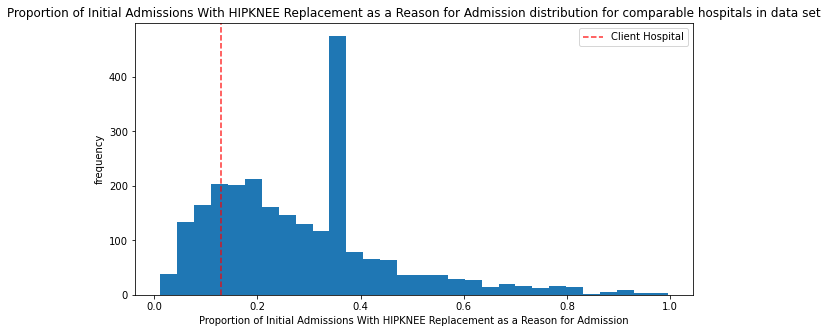

In [20]:
plot_compare('HIPKNEE_TA_PROP', 'Proportion of Initial Admissions With HIPKNEE Replacement as a Reason for Admission')

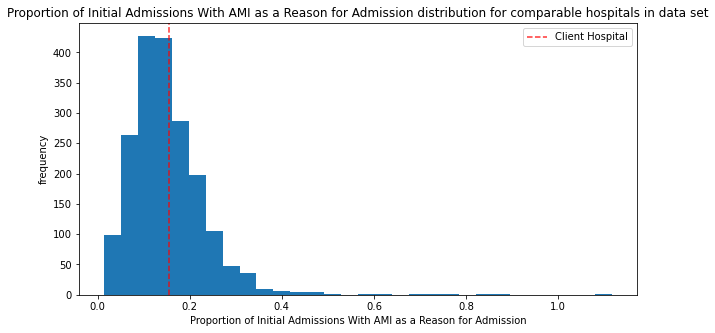

In [21]:
plot_compare('AMI_TA_PROP', 'Proportion of Initial Admissions With AMI as a Reason for Admission')

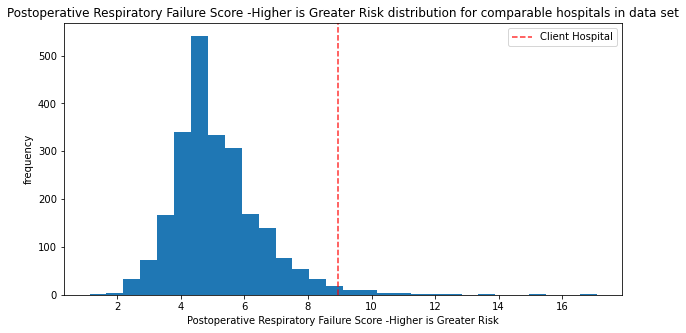

In [22]:
plot_compare('PSI_11', 'Postoperative Respiratory Failure Score -Higher is Greater Risk')

Perhaps most notably, our client hospital scored very poorly on normalized postoperative respiratory score (PSI-11) relative to the population. Also, our client hospital was toward the low end of the distribution for proportion of initial admissions with a (non-mutually exclusive) reason as hip/knee replacement surgery (HIP_KNEE_TA_PROP).

### Modeling Scenarios

It would be of interest to know if improvement on normalized postoperative respiratory score (PSI-11), to the population median, would improve the best model-based Readmission Rate for our client hospital. There is the possibility that increased vigilance, training and new protocols could lead to improvement in this metric. 

Also of interest, but perhaps less actionable, is knowing whether an increase in the proportion of initial admissions for hip/knee replacement surgery would yield an improved Readmission Rate. 

In [23]:
#In this function, we copy the Target Hospital data into a new data frame
#And then for each feature, and each of its deltas (changes from the original),
#we create the modified scenario dataframe (th2) and make a readmission rate prediction
#for it. The difference between the scenario's prediction and the current
#prediction is then calculated and returned.
def predict_increase(features, deltas):
    """Increase in modelled readmission rate by applying delta to feature.
    
    Arguments:
    features - list, names of the features in the hosp_data dataframe to change
    deltas - list, the amounts by which to increase the values of the features
    
    Outputs:
    Amount of increase in the predicted ticket price
    """
    
    th2 = X_client.copy()
    for f, d in zip(features, deltas):
        th2[features] += deltas
    return model.predict(th2).item() - model.predict(X_client).item()

#### For Impactful Features Where Target Hospital 'Underperforms', Calculate Delta to Get to Hospital Population Means

In [28]:
desired_delta_1 = hosp_data["PSI_11"].median() - targ_hosp.iloc[0,15]
desired_delta_1

-4.091966999999999

In [29]:
desired_delta_2 = hosp_data["HIPKNEE_TA_PROP"].median() - targ_hosp.iloc[0,26]
desired_delta_2

-0.1538909287139239

### Scenario 1: Reducing Postoperative Respiratory Failure Score to that of Hospital Population Median 

In [30]:
RR_increase = predict_increase(['PSI_11'], [desired_delta_1])
RR_increase

0.0

In [31]:
print(f'This scenario reduces model-predicted Readmission Rate by {RR_increase:.2f}%')

This scenario reduces model-predicted Readmission Rate by 0.00%


### Scenario 2: Increasing the Proportion of Inpatient Hip-Knee Replacement Cases to Hospital Population Median

In [32]:
RR_increase = predict_increase(['HIPKNEE_TA_PROP'], [desired_delta_2])
RR_increase

0.11198362279551866

In [33]:
print(f'This scenario reduces model-predicted Readmission Rate by {RR_increase:.2f}%')

This scenario reduces model-predicted Readmission Rate by 0.11%


## Business Case Conclusions

The good news for our client is that the best model predicts a Readmission Rate of 15.57%, while their actual Readmission Rate is 16.80. Even with the expected mean absolute error of 0.57, this suggests there is room for substantial improvement toward the 1% goal in the next cycle simply via regression to the mean.

Beyond that, we found that reducing postoperative respiratory failure score to the hospital population median is predicted to have little or no effect on readmission rate. So, while improving in this capacity may improve patient outcomes these improvements are not likely manifest in lowered Readmission Rate, per se. 

Increasing the proportion of admissions for hip-knee replacement in the overall case mix is predicted to improve Readmission Rate by approximately 10% of the goal to stay in good standing with CMS. While this may seem modest, coupled to the expected gain simply with mean reversion a small boost here could well help get to the 1% threshold. Perhaps modestly expanding staff and facilities for this procedure type could lure some patients in from other competing facilities in the area. Also, given that our client hospital is toward the low end of the distribution for proportion of this type of procedure, and we now have evidence that it is an impactful determinent of Readmission Rate, they can provide this context to CMS in an appeal if the 1% goal is not acheived within the next review cycle. 

